In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import os
import cv2
from PIL import Image
import copy
import time
import pickle


from tqdm.auto import tqdm
tqdm.pandas()

import glob

import torch
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler


from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_dir = '../dataset_generation/kaggle_dataset/'

In [3]:
loaded_model = torch.load('../saved_models/inceptionglaucoma_ben_inception_kaggle.h5', map_location=torch.device('cpu'))
loaded_model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [4]:
class ben_color(object):
    def __call__(self, img, sigmaX=10):
        """
        :param img: PIL): Image 

        :return: Normalized image
        """

        img = np.asarray(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.crop_image_from_gray(img)
        img = cv2.resize(img, (input_size, input_size))
        img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), sigmaX), -4, 128)
        return Image.fromarray(img)

    def crop_image_from_gray(self, img, tol=7):
        if img.ndim ==2:
            mask = img>tol
            return img[np.ix_(mask.any(1),mask.any(0))]
        elif img.ndim==3:
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            mask = gray_img>tol
            
            check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
            if (check_shape == 0):
                return img 
            else:
                img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
                img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
                img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
                img = np.stack([img1,img2,img3],axis=-1)
            return img

    def __repr__(self):
        return self.__class__.__name__+'()'

In [5]:
def predict_image(image, test_transforms):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    _input = Variable(image_tensor)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    _input = _input.to(device)
    output = loaded_model(_input)
    x = output.data.cpu().numpy()[0]
    x = [float(i) for i in x]
#     norm = [(i-min(x))/(max(x)-min(x)) for i in x]
#     norm = [round(100*i/sum(norm), 2) for i in norm]
    pred = x.index(max(x))
    return pred



def transform_image(image_url):

    test_transforms = transforms.Compose([
        ben_color(),
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    image = Image.open(image_url)
    return predict_image(image, test_transforms)

In [6]:
df_0 = pd.DataFrame(columns=['path', 'real'])
df_0['path'] = glob.glob("../dataset_generation/kaggle_dataset/0/*.*")
df_0['real'] = 0

df_1 = pd.DataFrame(columns=['path', 'real'])
df_1['path'] = glob.glob("../dataset_generation/kaggle_dataset/1/*.*")
df_1['real'] = 1

In [7]:
df = pd.concat([df_0, df_1])

In [8]:
df

,path,real
0,../dataset_generation/kaggle_dataset/0/189.jpg,0
1,../dataset_generation/kaggle_dataset/0/162.jpg,0
2,../dataset_generation/kaggle_dataset/0/176.jpg,0
3,../dataset_generation/kaggle_dataset/0/610.jpg,0
4,../dataset_generation/kaggle_dataset/0/360.jpg,0
...,...,...
163,../dataset_generation/kaggle_dataset/1/580.jpg,1
164,../dataset_generation/kaggle_dataset/1/345.jpg,1
165,../dataset_generation/kaggle_dataset/1/386.jpg,1
166,../dataset_generation/kaggle_dataset/1/609.jpg,1


In [9]:
df.real.value_counts()

0    482
1    168
Name: real, dtype: int64

In [10]:
input_size=299

In [11]:
df.head(10).path.progress_apply(transform_image)

0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    0
Name: path, dtype: int64

In [12]:
df['preds'] = df.path.progress_apply(transform_image) 

In [13]:
df

,path,real,preds
0,../dataset_generation/kaggle_dataset/0/189.jpg,0,0
1,../dataset_generation/kaggle_dataset/0/162.jpg,0,1
2,../dataset_generation/kaggle_dataset/0/176.jpg,0,1
3,../dataset_generation/kaggle_dataset/0/610.jpg,0,1
4,../dataset_generation/kaggle_dataset/0/360.jpg,0,0
...,...,...,...
163,../dataset_generation/kaggle_dataset/1/580.jpg,1,0
164,../dataset_generation/kaggle_dataset/1/345.jpg,1,1
165,../dataset_generation/kaggle_dataset/1/386.jpg,1,0
166,../dataset_generation/kaggle_dataset/1/609.jpg,1,1


In [14]:
precision_score(df.real, df.preds,  average='macro')

0.7405515781485585

In [15]:
recall_score(df.real, df.preds,  average='macro')

0.7975079035763684

In [16]:
accuracy_score(df.real, df.preds)

0.7830769230769231

In [18]:
confusion_matrix(df.real, df.preds)

array([[370, 112],
       [ 29, 139]])

<AxesSubplot:>

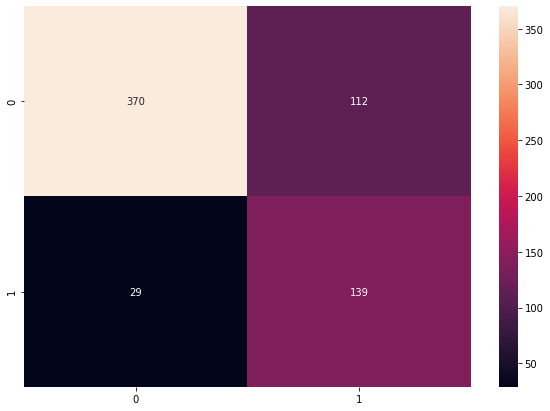

In [20]:
df_cm = pd.DataFrame(confusion_matrix(df.real, df.preds), index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  fmt='g')